# N-Tuple Learning 3

Created 2025-07-21

In [1]:
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import ipywidgets as widgets
from ipyevents import Event
import time
import gymnasium as gym
import torch
import torch.nn as nn
from typing import Any, cast
from collections import deque
import random
import cv2
from IPython.display import HTML
from matplotlib.patches import FancyArrow

In [2]:
sys.path.insert(1, str(Path("../..")))
from andreas2048.game import *
from andreas2048 import gym2048
env = gym2048.Env2048()

In [3]:
raise RuntimeError("STOP")

RuntimeError: STOP

### 1: DQN with n-Tuple networks revisited

In [ ]:
print(env.game)

<2048 Game: score: 588 - moves: 79 - highest tile: 64>
[[ 0  2  2  8]
 [ 0  4 16  2]
 [ 2  8 64  4]
 [ 0  8 32 16]]


In [7]:
class DQN(nn.Module):
    """ DQN implementation for a 2048 grid """

    def __init__(self, grid_shape: tuple[int, int], device: str) -> None:
        super().__init__()
        self.device = device
        assert grid_shape == (4,4)
        self.n_features = 14
        #self.powers = np.array([18**3, 18**2, 18, 1]).reshape(1,1,1,4)

        self.conv1 = nn.Conv3d(in_channels=self.n_features, out_channels=self.n_features, kernel_size=(1,1,2))
        self.conv2 = nn.Conv3d(in_channels=self.n_features, out_channels=self.n_features, kernel_size=(1,1,4))
        self.conv3 = nn.Conv3d(in_channels=self.n_features, out_channels=self.n_features, kernel_size=(1,1,4))
        self.conv4 = nn.Conv2d(in_channels=self.n_features, out_channels=self.n_features, kernel_size=(1,3))

        self.net = nn.Sequential(
            nn.Flatten(), # (n, 14, 4) -> (n, 56)
            nn.Linear(in_features=self.n_features*4, out_features=32),
            nn.Sigmoid(),
            nn.Linear(in_features=32, out_features=8),
            nn.Linear(in_features=8, out_features=1),
        )

        self.net.to(self.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Expects tensor of shape (n,14,4,3,4) """
        c1 = self.conv1.forward(x) # (n,14,4,3,4) -> (n,14,4,3,3)
        c2 = self.conv2.forward(x) # (n,14,4,3,4) -> (n,14,4,3,1)
        x = torch.cat([c1,c2], dim=-1) # (n,14,4,3,1) -> (n,14,4,3,4)
        x = self.conv3.forward(x).squeeze(-1) # (n,14,4,3,4) -> (n,14,4,3,1) -> (n,14,4,3)
        x = self.conv4.forward(x).squeeze(-1) # (n,14,4,3) -> (n,14,4,1) -> (n,14,4)
        x = torch.sigmoid(x)

        return self.net.forward(x)
    
    def V(self, x: np.ndarray, output_tensor: bool = False) -> np.ndarray|torch.Tensor:
        """ 
        Outputs the value function estimation by the model

        Args:
            x (np.ndarray): n-boards of shape (n,4,4) 

        Returns:
            V (np.ndarray): The value of the n-boards encoded as numpy array with shape (n,)
        
        """
        while len(x.shape) < 3: # (4,4) -> (1,4,4)
            x = x[None, ...]
        x = self.extract_tuples(x) # (n,4,4) -> (n,14,4,3,4)
        t = torch.from_numpy(x).float().to(self.device)
        #with torch.no_grad():
        vs = self.forward(t)
        vs = vs.squeeze(dim=-1)
        if output_tensor:
            return vs
        return vs.detach().numpy()
    

    def extract_tuples(self, grid: np.ndarray) -> np.ndarray:
        """
        Extract the n-tuples from n boards of shape (n, 4, 4). Returns the tuples as a numpy array of shape \n
        (n, |n_tuple|, 4, 4, 3) = (n, 14, 4, 3, 4) \n
        with the third value representing the rotation (Top, Right, Bottom, Left). The fourth values represents
        the current n-Tuple (index 0), the tuple prediction to the right (index 1) and left (index 2).
        The last values the ith value inside the n-tuple.
        """
        assert len(grid.shape) >= 3 and grid.shape[1] == 4 and grid.shape[2] == 4
        n_tuples = np.zeros(shape=(grid.shape[0],self.n_features,4,3,4), dtype=np.int8)
        for k in range(4):
            g_v = np.rot90(grid, k=k, axes=(1,2))
            n_tuples[:,0,k,0] = g_v[:,0,::-1] # Outer
            n_tuples[:,1,k,0] = g_v[:,1,:: 1] # Inner
            n_tuples[:,2,k,0] = g_v[:, [1,1,0,0], [-2,-1,-1,-2]] # Edge
            n_tuples[:,3,k,0] = g_v[:, [1,1,0,0], [-3,-2,-2,-3]] # Inner Edge
            n_tuples[:,4,k,0] = g_v[:, [2,1,1,0], [0,0,1,1]] # Left Z
            n_tuples[:,5,k,0] = g_v[:, [2,1,1,0], [1,1,2,2]] # Middle Z
            n_tuples[:,6,k,0] = g_v[:, [2,1,1,0], [2,2,3,3]] # Right Z
            n_tuples[:,7,k,0] = g_v[:, [2,1,1,0], [1,1,0,0]] # Left Mirror Z
            n_tuples[:,8,k,0] = g_v[:, [2,1,1,0], [2,2,1,1]] # Middle Mirror Z
            n_tuples[:,9,k,0] = g_v[:, [2,1,1,0], [3,3,2,2]] # Right Mirror Z
            n_tuples[:,10,k,0] = g_v[:, [2,1,0,0], [1,1,1,0]] # Left Arrow
            n_tuples[:,11,k,0] = g_v[:, [2,1,0,0], [2,2,2,1]] # Middle Arrow
            n_tuples[:,12,k,0] = g_v[:, [2,1,0,0], [3,3,3,2]] # Right Arrow
            n_tuples[:,13,k,0] = g_v[:, [1,0,0,0], [2,2,1,0]] # Edge Arrow
        
        n_tuples[:, :, :, 1] = State.table_cache[(4,4)][n_tuples[:,:,:,0,0], n_tuples[:,:,:,0,1], n_tuples[:,:,:,0,2], n_tuples[:,:,:,0,3]]
        n_tuples[:, :, :, 2] = State.table_cache[(4,4)][n_tuples[:,:,:,0,3], n_tuples[:,:,:,0,2], n_tuples[:,:,:,0,1], n_tuples[:,:,:,0,0]]
        #n_tuples[:, :, :, :4] = np.diff(n_tuples[:,:,:,:4], axis=-1, prepend=0)
        #n_tuples[:, :, :, :4] = np.diff(n_tuples[:,:,:,:4], axis=-1, prepend=0)
        return n_tuples
    
# Testing the implementation
net = DQN(grid_shape=env.game.shape, device="cpu")
print(net.extract_tuples(env.game.grid[None, :]).shape)
net.V(env.game.grid)

(1, 14, 4, 3, 4)


array([0.38039225], dtype=float32)

In [12]:
class DQNAgent:
    """ Implements a simple DQN agent """
    
    def __init__( self,
                env: gym2048.Env2048, 
                learning_rate: float = 0.05, 
                gamma: float = 0.99,
                epsilon: float = 1.0,
                epsilon_decay = 0.005,
                epsilon_min = 0.001,
               ) -> None:
        self.env = env
        self.device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(grid_shape=env.game.grid.shape, device=self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        self.history: list[Game] = []

        self.replay_buffer: deque[tuple[State, int]] = deque(maxlen=10_000)
        self.batch_size: int = 200
        self._loss = 0

    def reset(self) -> None:
        if env.game.alive == False:
            #self.replay_buffer.extend([(s.clone(rot=k), env.game.score) for s in env.game.history for k in range(4)])
            self.replay_buffer.extend([(s, env.game.score) for s in env.game.history])
        env.reset()
        self.history.append(env.game)

    def update(self, game: Game, mode: Literal["Batch", "Last"] = "Last") -> None:
        match mode:
            case "Batch":
                if len(self.replay_buffer) < self.batch_size:
                    return
                #weights = np.log2([s.highest_tile for s, score in self.replay_buffer])
                batch = random.choices(self.replay_buffer, k=self.batch_size)
                states, scores = cast(tuple[list[State], list[int]], zip(*batch))

                grids = np.array([s.grid for s in states])
                scores = np.array([score for score in scores])
                scores = torch.from_numpy(scores).float().to(self.device)
            case "Last":
                grids = np.array([s.grid for s in game.history])
                scores = np.array([game.score for i in range(len(game.history))])
                scores = torch.from_numpy(scores).float().to(self.device)

        #weight_fn = lambda score: 0.2 + 0.8/(1+np.exp(-(np.log(score+1)-self.model.weight_mean)/self.model.weight_width))
        #weights = np.array([weight_fn(s.score) for s in game.history])
        #weights = torch.from_numpy(weights).float().to(self.device)

        vs = cast(torch.Tensor, self.model.V(grids, output_tensor=True))
        loss: torch.Tensor = nn.MSELoss()(vs, scores)
        self._loss = loss.detach().numpy()
        #loss = ((vs - scores) ** 2).mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def step(self) -> bool:   
        next_state, reward, done, truncated, info = env.step(self.predict())
        return not(done or truncated)
    
    def predict(self) -> Action:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample(mask=mask)
        actions = self.get_qv()
        return max(actions, key=actions.get)
    
    def get_qv(self) -> dict[Action, float]:
        qvs = {}
        for a in Action:
            next_states = self.env.game.state.get_next_states(a)
            if len(next_states) == 1:
                continue
            next_states_grid = np.array([s.grid for s in next_states.keys()])
            v = self.model.V(next_states_grid)
            qvs[a] = np.sum([p*v for p, v in zip(next_states.values(), v)])
        return qvs
    
    @property
    def scores(self) -> list[float]:
        return [g.score for g in self.history]
    
    @property
    def highest_tiles(self) -> list[int]:
        return [g.highest_tile for g in self.history]
    
    @property
    def move_counts(self) -> list[int]:
        return [g.move_count for g in self.history] 
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * (1 - self.epsilon_decay))


    def adjust_training_weights(self) -> None:
        pass
        #self.model.weight_mean = np.log(max(100, np.mean(self.scores[-500:])))
        #self.model.weight_width = 2


env = gym2048.Env2048(shape=(4,4))
agent = DQNAgent(env=env, gamma=0.99, learning_rate=0.001, epsilon=0.2, epsilon_decay=0.001, epsilon_min=0.05)
episode = -1

In [ ]:
episode += 1
episode_cap = 10_000
try:
    for episode in range(episode, episode_cap):
        agent.reset()

        while env.game.alive:
            done = agent.step()
        agent.update(env.game, mode="Batch")
        agent.decay_epsilon()
        #agent.adjust_training_weights()

        s = f"Episode {episode:>4}/{episode_cap}"
        for v in [
            f"Score: {env.game.score:5}", 
            f"Highest tile: {env.game.highest_tile:4}",
            f"Length: {env.game.move_count:3}",
            f"Epsilon: {agent.epsilon:1.3f}",
            f"Average rolling score: {np.mean(agent.scores[max(0,episode-50):]):1.3f}",
            f"√Loss: {np.sqrt(agent._loss):7.1f}",
        ]:
            s += f" - {v}"
        print(s)

except KeyboardInterrupt:
    pass

ax1 = plt.subplot()
ax2 = ax1.twinx()
p1 = ax1.plot(np.log2(agent.highest_tiles), label="Highest tile", c="orange")
scores = agent.scores
p2 = ax2.plot([np.mean(scores[max(0,i-50):i]) for i in range(1,len(scores)+1)], label="Scores")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Highest tile")
ax2.set_ylabel("Score")
ax1.yaxis.label.set_color(p1[0].get_color())
ax2.yaxis.label.set_color(p2[0].get_color())
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{2**x:n}"))
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

Episode  443/10000 - Score:  1492 - Highest tile:  128 - Length: 148 - Epsilon: 0.129 - Average rolling score: 798.353 - √Loss:   960.7
Episode  444/10000 - Score:  1640 - Highest tile:  128 - Length: 169 - Epsilon: 0.128 - Average rolling score: 822.745 - √Loss:   967.4
Episode  445/10000 - Score:  3092 - Highest tile:  256 - Length: 253 - Epsilon: 0.128 - Average rolling score: 871.373 - √Loss:  1048.6
Episode  446/10000 - Score:   348 - Highest tile:   32 - Length:  64 - Epsilon: 0.128 - Average rolling score: 871.294 - √Loss:  1033.1
Episode  447/10000 - Score:   292 - Highest tile:   32 - Length:  54 - Epsilon: 0.128 - Average rolling score: 868.941 - √Loss:  1118.2
Episode  448/10000 - Score:   540 - Highest tile:   64 - Length:  74 - Epsilon: 0.128 - Average rolling score: 873.961 - √Loss:  1051.3
Episode  449/10000 - Score:  1088 - Highest tile:  128 - Length: 118 - Epsilon: 0.128 - Average rolling score: 871.843 - √Loss:  1096.9
Episode  450/10000 - Score:   676 - Highest tile

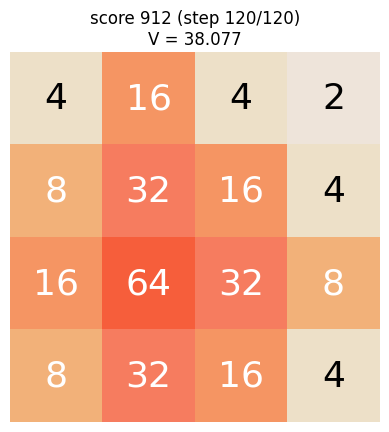

In [14]:
HTML(agent.history[20].render_game(value_func=lambda x: f"V = {agent.model.V(x)[0]:1.3f}").to_jshtml())